5-8-19: 01-data_processing.ipynb is for initial data loading, image scaling/resizing, and vectorizing.

In [30]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import glob #good for 
import cv2

import io, time
tm = time.time()

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 12.9 ms


In [31]:
date="05092019" #defining the date for saving files later
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

time: 6.45 ms


# first pass all images through autocropper

In [32]:
def auto_crop_process(file):
    global OUTPUT_DIR
    # Print out some file information
    image = Image.open(file)
    image_width = image.size[0]
    image_height = image.size[1]

#     print("Image type: " + image.format + "; mode: " + image.mode + "; dimensions: " + str(image_width) + "x" + str(image_height))
    
    ######   MODIFIED START  ##########
    if image.mode!="RGB":
        image= image.convert(mode='RGB')
    else: pass
    ######   MODIFIED END  ##########

    # Sample background color
    def rgb_tuple_to_str(tuple):
        return 'rgb(' + str(tuple[0]) + ', ' + str(tuple[1]) + ', ' + str(tuple[2]) + ')'

    def is_like_bg_color(color):
        color_r, color_g, color_b = color[0], color[1], color[2]
        bg_r, bg_g, bg_b = bg_color[0], bg_color[1], bg_color[2]
        r_similar, g_similar, b_similar = False, False, False

        if color_r in range(bg_r - TOLERANCE, bg_r + TOLERANCE):
            r_similar = True
            
        if color_g in range(bg_g - TOLERANCE, bg_g + TOLERANCE):
            g_similar = True
            
        if color_b in range(bg_b - TOLERANCE, bg_b + TOLERANCE):
            b_similar = True

        return r_similar and g_similar and b_similar

#     print("Sampling background color...")
    pixel_map = image.load()
    x_offset = image_width * 0.05
    y_offset = image_height * 0.05

    ul_color = pixel_map[x_offset, y_offset]
    ur_color = pixel_map[image_width - x_offset, y_offset]
    ll_color = pixel_map[x_offset, image_height - y_offset]
    lr_color = pixel_map[image_width - x_offset, image_height - y_offset]
    
    
    ######   MODIFIED START  ##########
    bg_color = image.getpixel((1, 1))#()#()  
    ###### MODIFIED END ###########


    if ul_color == ur_color and ur_color == ll_color and ll_color == lr_color:
        bg_color = ul_color
#         print("Sampled background color: " + rgb_tuple_to_str(ul_color))

    # Search for top edge
#     print("Searching for top edge...")
    top_edge_coords = []

    for i in range(0, image_width, int(image_width / 10)):
        for y in range(0, image_height - 1):
            if not is_like_bg_color(pixel_map[i, y]):
                top_edge_coords.append(y)
                break

    top_edge_coord = top_edge_coords[0]
    for c in top_edge_coords:
        if c < top_edge_coord:
            top_edge_coord = c

#     print("Found top edge at y = " + str(top_edge_coord))

    # Search for bottom edge
#     print("Searching for bottom edge...")
    bottom_edge_coords = []

    for i in range(0, image_width, int(image_width / 10)):
        for y in range(image_height - 1, 0, -1):
            if not is_like_bg_color(pixel_map[i, y]):
                bottom_edge_coords.append(y)
                break

    bottom_edge_coord = bottom_edge_coords[0]
    for c in bottom_edge_coords:
        if c > bottom_edge_coord:
            bottom_edge_coord = c

#     print("Found bottom edge at y = " + str(bottom_edge_coord))

    # Search for left edge
#     print("Searching for left edge...")
    left_edge_coords = []

    for i in range(0, image_height, int(image_height / 10)):
        for x in range(0, image_width - 1):
            if not is_like_bg_color(pixel_map[x, i]):
                left_edge_coords.append(x)
                break

    left_edge_coord = left_edge_coords[0]
    for c in left_edge_coords:
        if c < left_edge_coord:
            left_edge_coord = c

#     print("Found left edge at x = " + str(left_edge_coord))
    
    # Search for right edge
#     print("Searching for right edge...")
    right_edge_coords = []

    for i in range(0, image_height, int(image_height / 10)):
        for x in range(image_width - 1, 0, -1):
            try:
                if not is_like_bg_color(pixel_map[x, i]):
                    right_edge_coords.append(x)
                    break
            except IndexError:
                pass

    right_edge_coord = right_edge_coords[0]
    for c in right_edge_coords:
        if c > right_edge_coord:
            right_edge_coord = c

#     print("Found right edge at x = " + str(right_edge_coord))

    # Crop image
#     print("Cropping image...")
    cropped_image = image.crop((left_edge_coord, top_edge_coord, right_edge_coord, bottom_edge_coord))

    # Save image to output dir
    file_name, file_ext = os.path.splitext(file)
    output_file_name = os.path.basename(file_name) + '_processed' + file_ext
    output_file_path = os.path.join(os.getcwd(), OUTPUT_DIR, output_file_name)
#     print("Saving image to " + output_file_path)
    cropped_image.save(output_file_path)

time: 11.9 ms


In [33]:
def auto_crop(input_dir, output_dir):
    image_exts = [ '.jpg', '.jpeg', '.png', ".JPG",".JPEG", ".PNG" ]
    #input_dir = Path("../data/raw/no/") #os.path.join(os.getcwd(), 'img')
    #output_dir = Path("../data/processed/autotest/no/")#os.path.join(os.getcwd(), 'out')

    # Create output directory, if not present
    try:
        os.stat(output_dir)
    except:
        os.mkdir(output_dir)

    # Iterate over working directory
    for file in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file)
        file_name, file_ext = os.path.splitext(file_path)

        # Check if file is an image file
        if file_ext not in image_exts:
            #print("Skipping " + file + " (not an image file)")
            continue
        else:
            #print()
            #print("Processing " + file + "...")
            auto_crop_process(file_path)


time: 4.96 ms


## running autocrop on yes and no folder

In [34]:
##running autocrop on yes folder
INPUT_DIR = Path("../data/raw/no/")
#OUTPUT_DIR = 'out'
OUTPUT_DIR=Path("../data/processed/autotest/no/")
TOLERANCE = 11

auto_crop(INPUT_DIR, OUTPUT_DIR)

##running autocrop on no folder
INPUT_DIR = Path("../data/raw/yes/")
#OUTPUT_DIR = 'out'
OUTPUT_DIR=Path("../data/processed/autotest/yes/")
TOLERANCE = 11

auto_crop(INPUT_DIR, OUTPUT_DIR)

time: 4.19 s


# Second pass: my crop/scale algorithm

In [35]:
def max_dimensions():
    """use to determine the max height and width of images to determine final image size to standardize to.
    the following functions will be tuned assuming this has been run and interpreted"""
    
    global allyes, allno
    #finding max dimensions
    dim_list=[]
    for i in range(0,len(allyes)):
        dim_list.append(cv2.imread(allyes[i]).shape)
    for i in range(0,len(allno)):
        dim_list.append(cv2.imread(allno[i]).shape)
    #dim_list
     
    largest_l=0 #longest height
    largest_w=0 #longst width
    i=0
    i_l=0 #index of tallest
    i_w=0 #index of widest
    for element in dim_list:
        if element[0]>largest_l:
            largest_l=element[0]
            i_l=i
        else: pass
        if element[1]>largest_w:
            largest_w=element[1]
            i_w=i
        else: pass
        i+=1
    
    return(largest_l, largest_w, i_l, i_w)


time: 1.49 ms


In [36]:
def img_std_size1(im, h):

    h=h #desired size decided based on output from max_dimensions
    
    ##scaling a pictures smallest dimension to 1500
    old_size=im.shape[:2]
    
    scale_ratio=h/min(old_size)
    
    new_size = tuple([int(round(x*scale_ratio)) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    
    #cropping the rescaled image to 1500x1500
    x1=int((im.shape[1]/2) -(h/2))
    y1=int((im.shape[0]/2) -(h/2))

    crop_img = im[y1:y1+h, x1:x1+h].copy() #the .copy() makes sure it doesn't change the image inline and saves it as new
    
    return(crop_img)


def img_std_size2(im, h):
    'scale the largest to 1500 and add black background'
    from cv2 import copyMakeBorder
#     print("img size:", img.shape)
    
    h=h #desired size
    ##scaling a pictures smallest dimension to 1500
    old_size=im.shape[:2]

    ##scaling image down by factor of 1500/max dimension
    scale_ratio=h/max(old_size) #scale it up or down to max=1500
    new_size = tuple([int(x*scale_ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))

    ###adding appropriate amount of boarder
    #dealing with odd numbers by adding a pixel on top or left
    i=0
    if im.shape[0] %2 ==1: #if number is odd
        i=1
    j=0
    if im.shape[1] %2 ==1: #if number is odd
        j=1
    
    top=int((h-im.shape[0])/2)+i
    bottom=int((h-im.shape[0])/2)
    left=int((h-im.shape[1])/2)+j
    right=int((h-im.shape[1])/2)

    color = [0, 0, 0]
    border_img=copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return(border_img)

def master_img_scale(im, h=1500):
    if max(im.shape)>h:
        scaled_im = img_std_size1(im, h=h)
    else:
        scaled_im = img_std_size2(im, h=h)
    return(scaled_im)

time: 4.46 ms


In [37]:
def main(newsize=1500):
    X=[]    #
    y=[]    #onehot encoded y label
    
    global allyes, allno
    
    #allyes,allno=gather_image_files()
    
    for myFile in allyes:
        image = cv2.imread(myFile)#, cv2.COLOR_BGR2RGB)
        scaled= master_img_scale(image, h=newsize)
        X.append (np.array(scaled))
        y.append([1., 0.])
    for myFile in allno:
        image = cv2.imread(myFile)#, cv2.COLOR_BGR2RGB)
        scaled= master_img_scale(image, h=newsize)
        X.append (np.array(scaled))
        y.append([0., 1.])

    X = np.array(X,dtype='float32')  / 255.0 #convert to np array and scale values to between 0-1.
    #X= X[:,:,:,0] #each rgb layer provides same info since it's greyscaled already
    y = np.array(y,dtype='float64') #as mnist
    
    return(X,y)

time: 2.98 ms


In [38]:
##filepath of autocropped images
allyes=glob.glob("../data/processed/autotest/yes/"+"*")#'*.[pjJ][npP][gG]') #grabs all jpg and png files
allno=glob.glob("../data/processed/autotest/no/"+"*")#'*.[pjJ][npP][gG]')


time: 12.4 ms


In [39]:
allno[:3]

['../data/processed/autotest/no\\1 no_processed.jpeg',
 '../data/processed/autotest/no\\10 no_processed.jpg',
 '../data/processed/autotest/no\\11 no_processed.jpg']

time: 5.95 ms


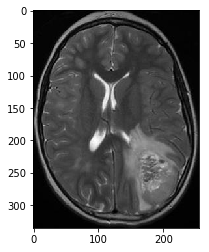

time: 178 ms


In [40]:
plt.imshow(cv2.imread(allyes[0]))

## run max dimensions to see the maximum width and height of all images in allyes and allno.
* use this to determine h for main()

In [41]:
max_dimensions()

(1403, 1247, 104, 104)

time: 438 ms


In [42]:
X,y= main(newsize=400)#h=1250) 1250 had issue at number 48

time: 1.09 s


### Visualize cropping

0


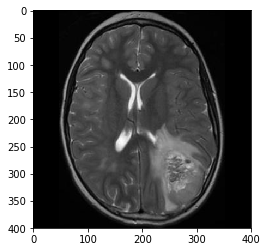

1


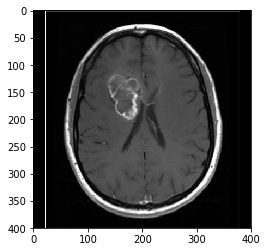

2


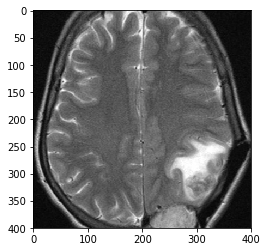

3


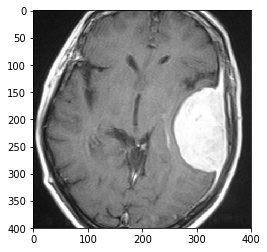

4


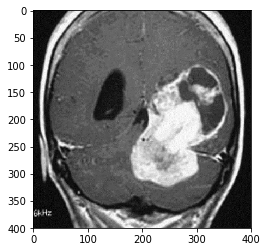

5


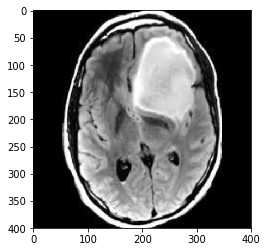

6


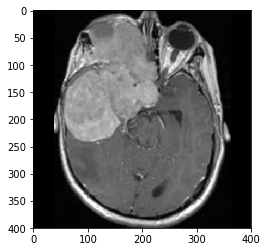

7


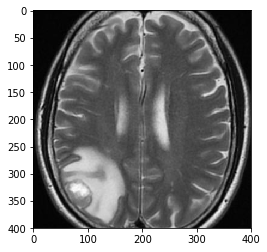

8


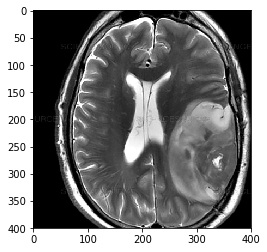

9


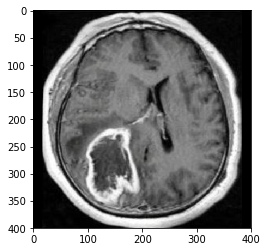

10


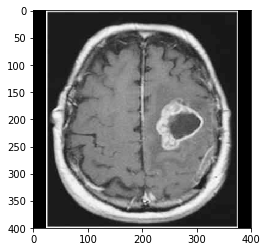

11


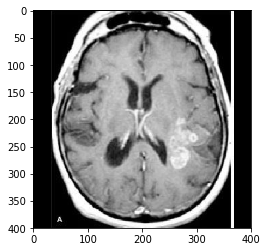

12


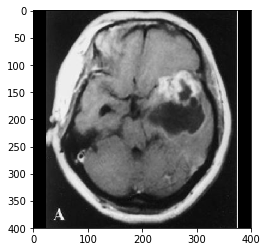

13


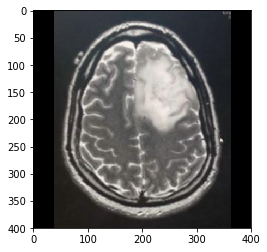

14


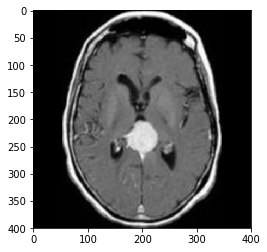

15


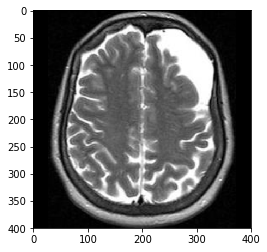

16


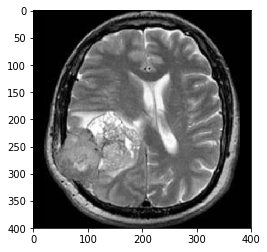

17


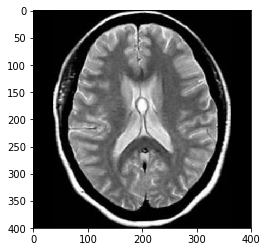

18


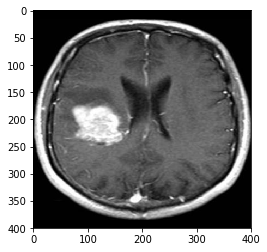

19


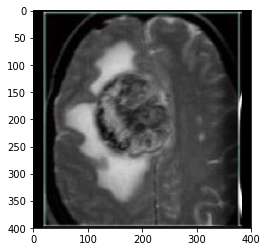

20


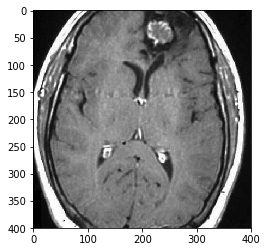

21


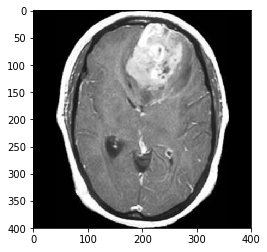

22


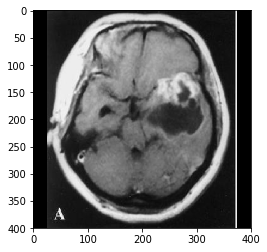

23


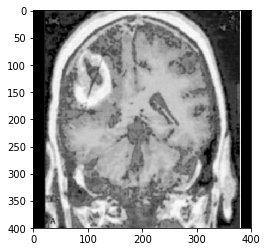

24


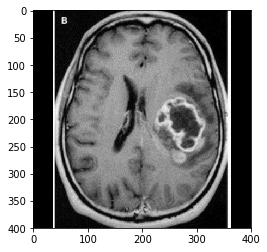

25


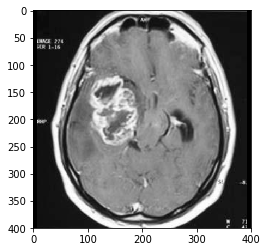

26


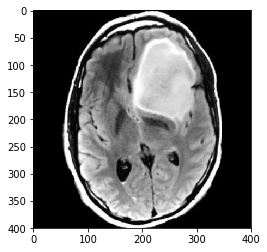

27


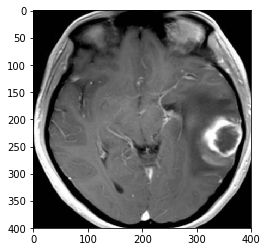

28


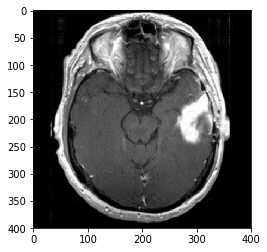

29


KeyboardInterrupt: 

time: 3.77 s


In [43]:
# for i in range(0,50):
#     print(i)
#     plt.imshow(X[i])
#     plt.show()

In [ ]:
# for i in range(160,247):
#     print(i)
#     plt.imshow(X[i])
#     plt.show()

# Third pass: scale images down to desired size

160


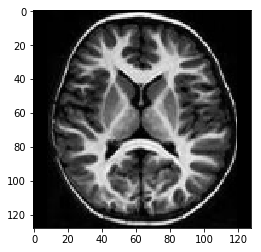

161


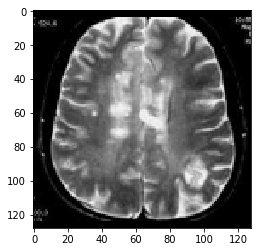

162


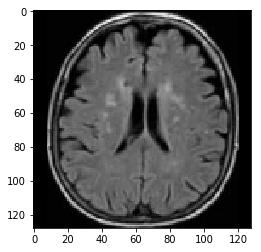

163


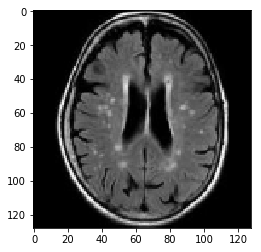

164


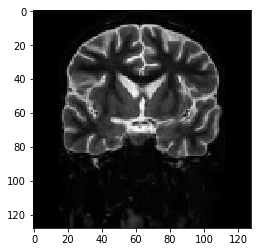

165


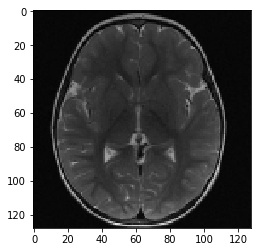

166


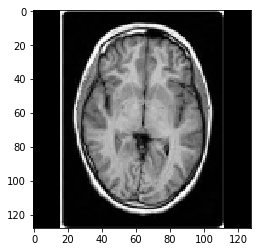

167


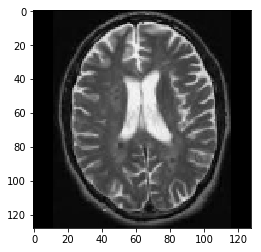

168


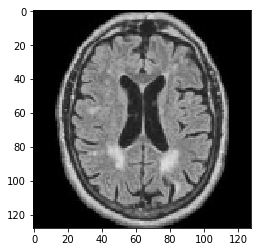

169


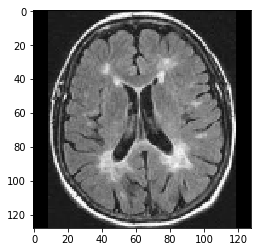

170


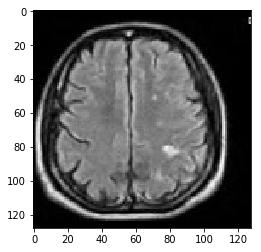

171


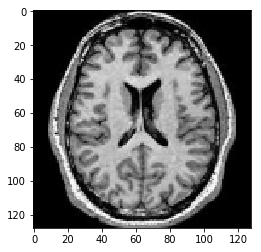

172


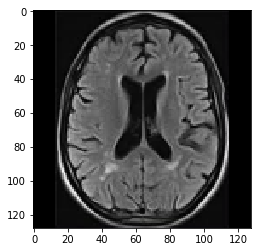

173


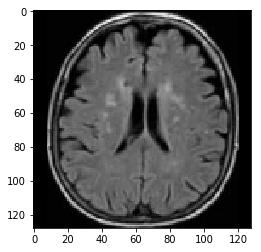

174


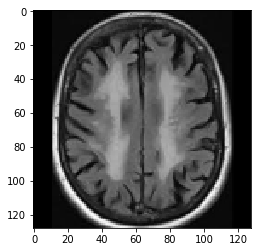

175


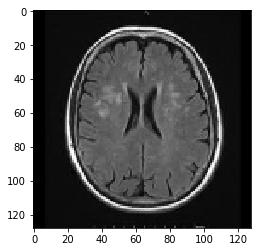

176


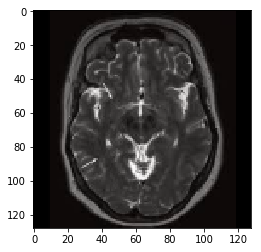

177


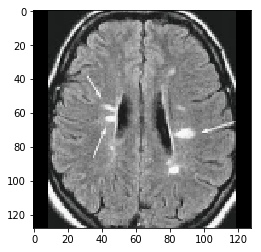

178


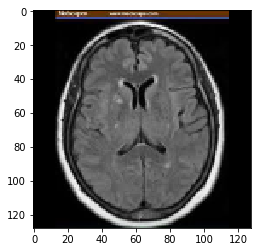

179


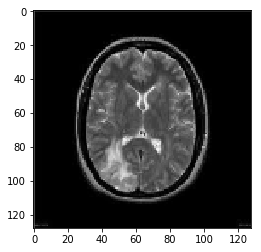

180


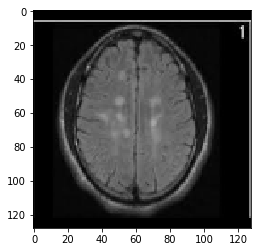

181


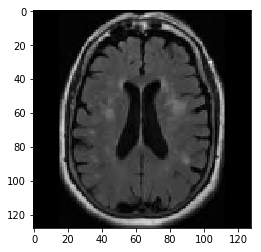

182


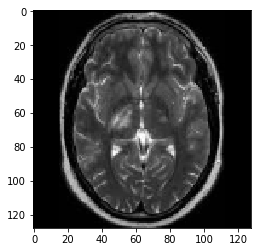

183


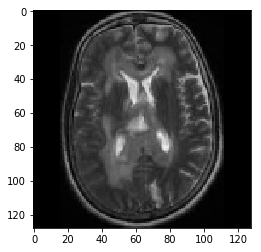

184


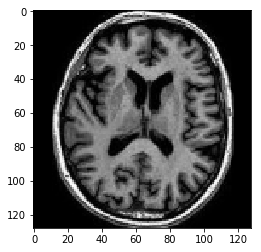

185


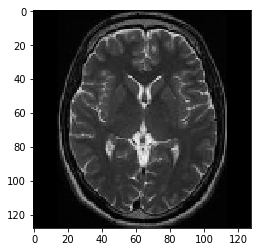

186


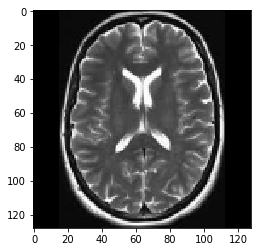

187


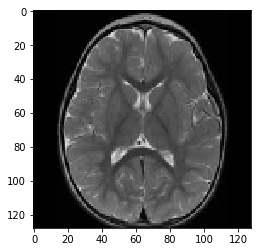

188


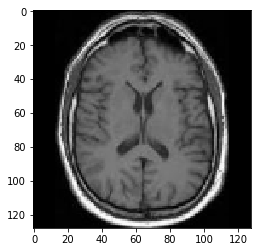

189


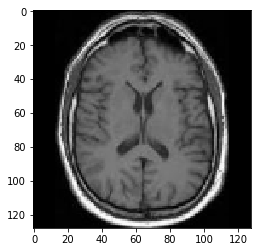

190


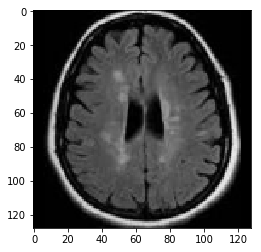

191


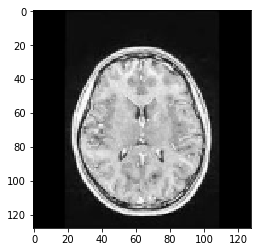

192


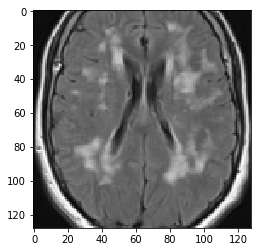

193


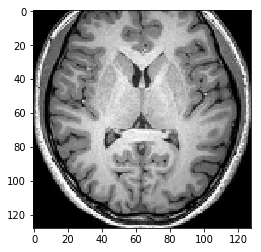

194


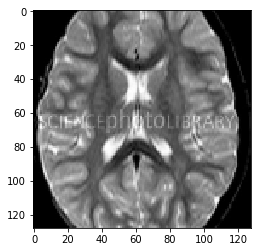

195


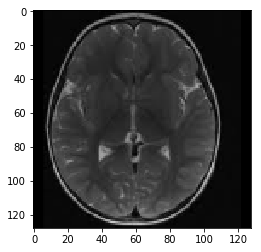

196


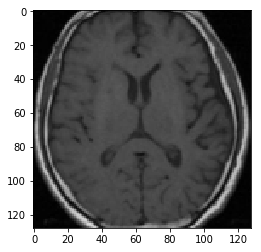

197


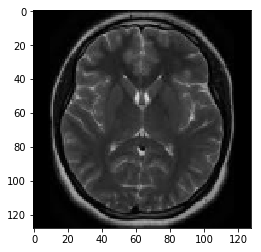

198


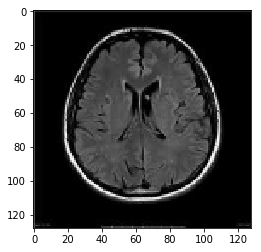

199


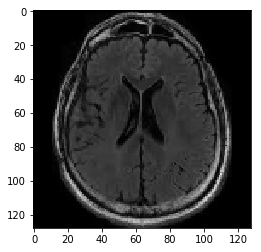

200


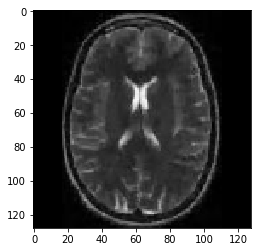

201


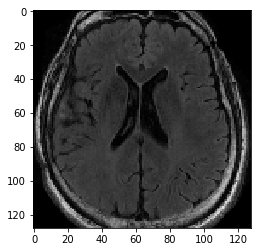

202


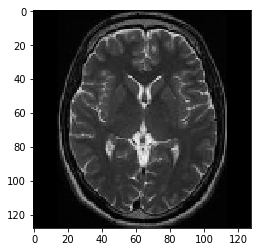

203


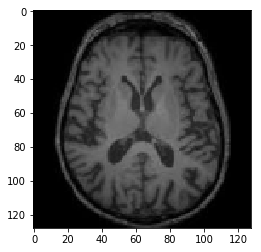

204


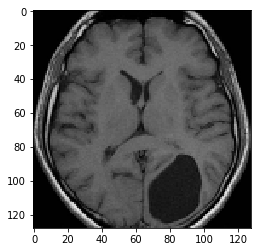

205


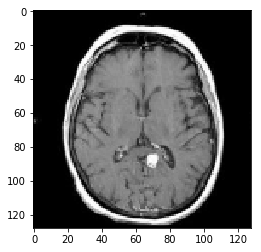

206


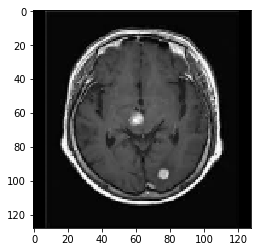

207


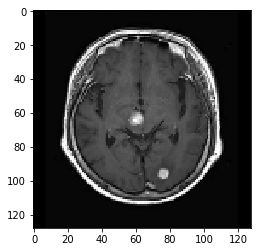

208


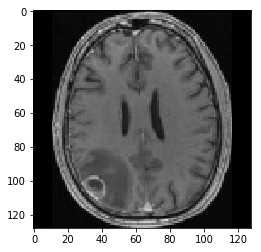

209


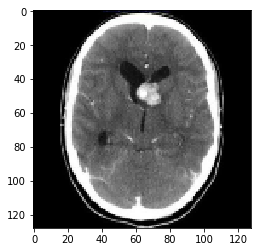

210


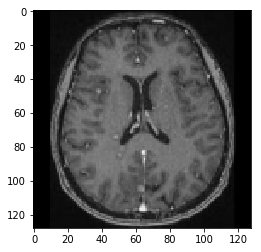

211


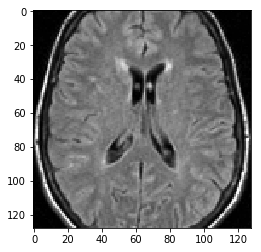

212


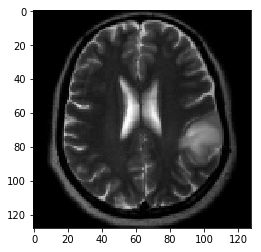

213


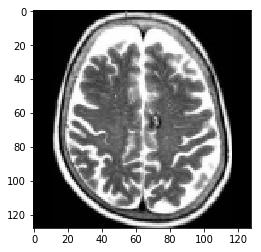

214


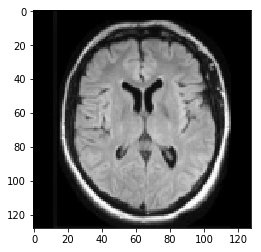

215


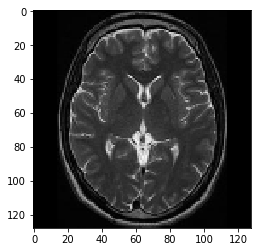

216


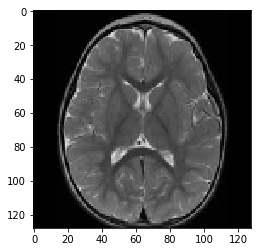

217


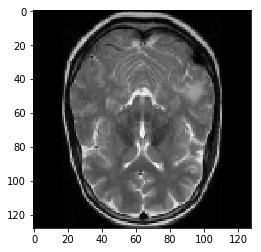

218


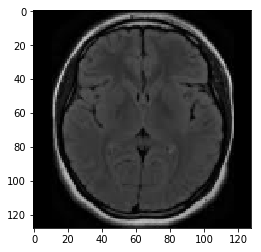

219


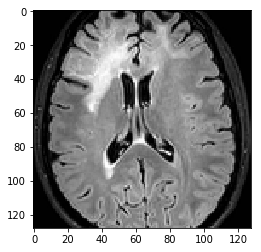

220


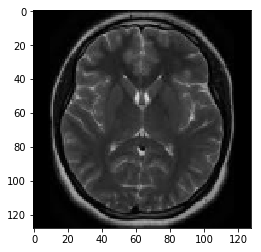

221


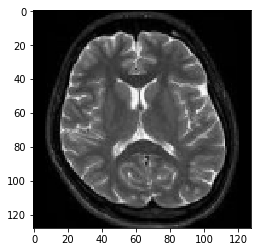

222


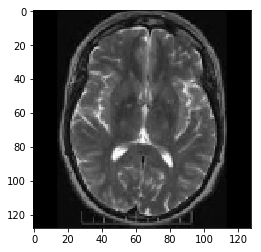

223


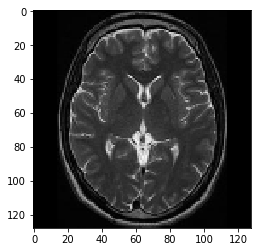

224


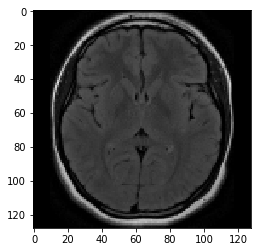

225


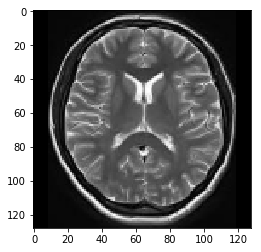

226


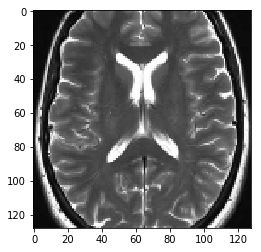

227


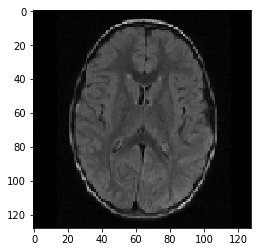

228


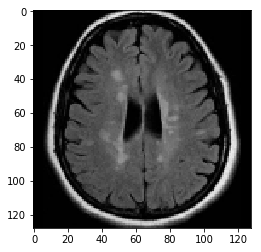

229


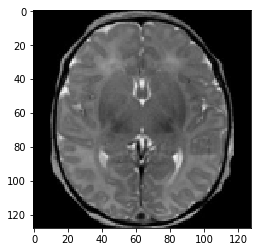

230


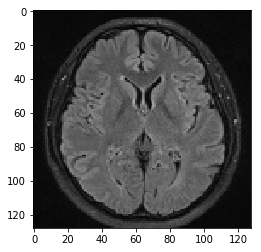

231


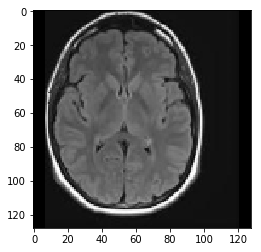

232


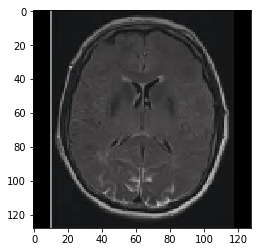

233


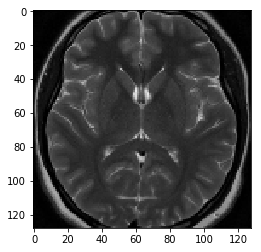

234


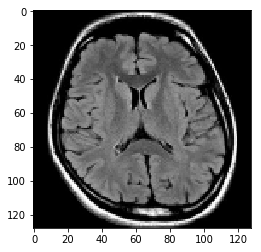

235


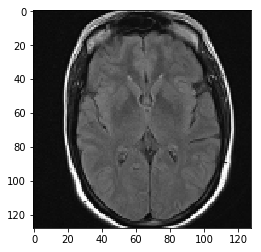

236


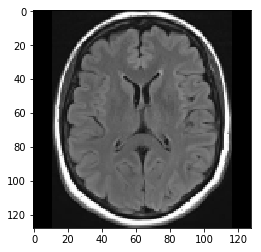

237


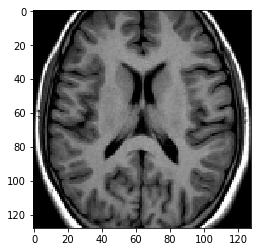

238


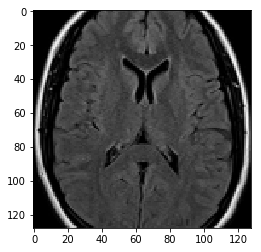

239


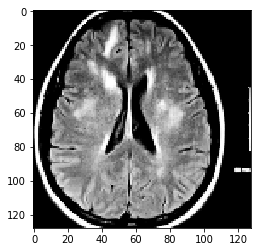

240


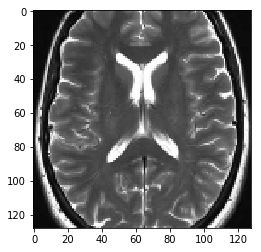

241


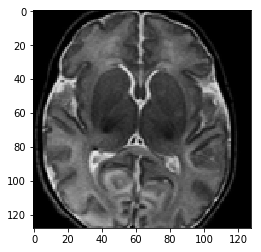

242


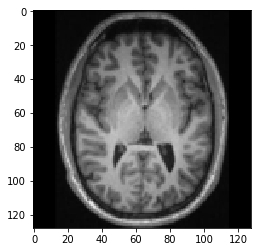

243


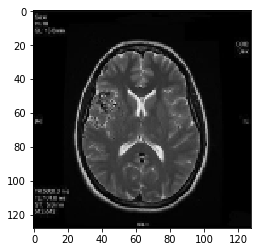

244


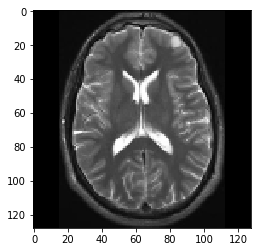

245


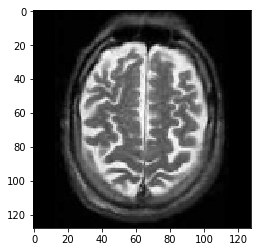

246


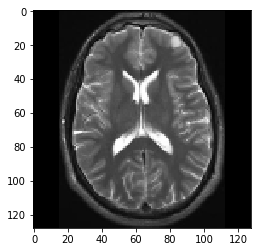

time: 8.69 s


In [44]:
#test
#im = cv2.resize(im, (new_size[1], new_size[0]))
desired_pixel_size=128 #200
size=tuple([desired_pixel_size,desired_pixel_size])
for i in range(160,247):
    print(i)
    plt.imshow(cv2.resize(X[i],size)) #plt.imshow(X[i])
    plt.show()

In [46]:
X.shape

(253, 400, 400, 3)

time: 1.98 ms


# save/load

In [45]:

np.save(Path("../data/processed/%s_X.npy" %(date)),X)
np.save(Path("../data/processed/%s_y.npy" %(date)),y)

#can load with:
#X=np.load("../data/processed/%s_X.npy"%(date))
#y=np.load("../data/processed/%s_y.npy"%(date))

time: 1.29 s


# testing autocropper